In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from random import random

In [604]:
class Tournament(object):
    def __init__(self):
        # team Data
        self.team_dict = {}
        # Completed fixture Data
        self.fixture_list = []
        # Pending fixture Data
        self.pending_fixture_list = []
        # Default seed
        self.max_seed = 0
        # Points for a win
        self.win_pts = 3
        #Points for a draw
        self.draw_pts = 1
        #Points for a bye
        self.bye_pts = 3
        # Matchday Count
        self.matchday = 0
        # Minimum Possible Pairings
        self.min_pairings = 20
        # Tiebreaker
        self.tiebreaker = 'sonneborn-berger'
        # Whether to consider home and away
        self.home_away = True
        # Maximum number of meetings
        self.max_meetings = 1
        # Filter Category allocation for hybrid fixtures
        self.allocation = {}
        # Country dict for tracking international tally
        self.country_dict = {}
    
    def add_team(self, name, seed = 'none', points = 0, **kwargs):
        if seed == 'none':
            seed = self.max_seed
        
        self.team_dict[name] = {'seed': seed,
                                 'points': points,
                                 'opponents': [],
                                'wins': [],
                                'draws': [],
                                'home_away': [],
                                'home_away_restriction': None,
                                'home_away_gap': 0,
                                 'byes': 0, 
                                'sonneborn-berger': 0}
        
        self.team_dict[name].update(kwargs)
        
    def teams_df(self, sonneborn_berger = True):
        if sonneborn_berger:
            self.sonneborn_berger()
        df = pd.DataFrame(self.team_dict).transpose().sample(frac = 1).sort_values(by = ['points',self.tiebreaker, 'seed'], 
                                                                                   ascending = [False,False,True]).reset_index(names = 'name')
        return df
    
    # Pair all teams with no extra restrictions
    def all_fixtures(self):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        self.create_fixtures(teams_df)
    
    # Pair all teams with one filter
    def filtered_fixtures(self, filter_):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        teams_divided = [teams_df[teams_df[filter_] == x].reset_index(drop=True) for x in teams_df[filter_].drop_duplicates()]
        for teams in teams_divided:
            self.create_fixtures(teams, designation = 'domestic')
            
    def hybrid_fixtures(self, filter_):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        filter_categories =  teams_df[filter_].drop_duplicates()
        teams_divided = [teams_df[teams_df[filter_] == x].reset_index(drop=True) for x in filter_categories]
        
        # Sort teams into top tier and filter other teams
        top_teams = []
        other_teams = []
        for table, category in zip(teams_divided, filter_categories):
            allocation = self.allocation[category]
            top_teams.append(table[:allocation])
            other_teams.append(table[allocation:].reset_index(drop = True))
        top_tier_teams = pd.concat(top_teams).sort_values(by = ['points','seed'], ascending = [False,True]).reset_index(drop = True)
        
        # Create fixtures, strongly prefer different country
        self.create_fixtures(top_tier_teams, avoid_same_country = 2, designation = 'international')
        for teams in other_teams:
            self.create_fixtures(teams)
    
    def final_fixtures(self, filter_, gap_cutoff):
        self.matchday += 1
        teams_df = self.teams_df()
        continent_leader = teams_df.points[0]
        
        # Divide teams into top and low tiers
        top_teams_count = sum(continent_leader - teams_df.points <= gap_cutoff)
        if top_teams_count % 2 == 1:
            if top_teams_count == 1:
                top_teams_count = 0
            else:
                top_teams_count += 1
        
        top_tier_teams = teams_df[:top_teams_count]
        low_tier_teams = teams_df[top_teams_count:]

        if len(top_tier_teams) % 2 == 1:
            print('Odd teams')
            print(top_tier_teams)
            
        # Divide and filter low tier teams
        national_leaders = list(teams_df.drop_duplicates(filter_).points)

        filter_categories =  teams_df[filter_].drop_duplicates().reset_index(drop = True)
        teams_divided = [low_tier_teams[low_tier_teams[filter_] == x].reset_index(drop=True) for x in filter_categories]

        for idx, table in enumerate(teams_divided):
            allocation = sum(national_leaders[idx] - table.points <= gap_cutoff)
            if allocation % 2 == 1:
                if (filter_categories[idx] not in top_tier_teams[filter_].values) & (allocation == 1):
                    allocation = 0
                else:
                    allocation += 1
            teams_divided[idx] = table[:allocation].reset_index(drop = True)
            if len(teams_divided[idx]) % 2 == 1:
                print('Odd teams')
                print(teams_divided[idx]['country'][0])
                
        # Create Fixtures, prefer different country
        if len(top_tier_teams) > 0.5:
            self.create_fixtures(top_tier_teams, avoid_same_country = 1, cutoff = gap_cutoff, designation = 'final')
        for teams in teams_divided:
            if len(teams) > 0.5:
                self.create_fixtures(teams, cutoff = gap_cutoff, designation = 'final')

    def create_fixtures(self, teams_df, avoid_same_country = 0, cutoff = 100, designation = 'domestic'):    
        # Check whether a team needs to be given a bye
        byeNeeded = (len(teams_df) % 2 == 1)
        # if byeNeeded:
        #     print('Bye Needed')
        #     print(teams_df.country[0])
        #     print(len(teams_df))
        
        # Create a network graph
        G = nx.Graph()
        
        # Parameters for creating possible pairings
        reach = max(max(teams_df.points.value_counts()), self.min_pairings, self.matchday)
        step = max(int(reach/self.min_pairings), 1)
        
        # Add edges for each pairing of teams
        for idx, data1 in teams_df.iterrows():
            team1 = data1['name']
            options = teams_df[idx + 1 : idx + reach : step]
            
            for idx2, data2 in options.iterrows():
                team2 = data2['name']
                
                ptsGap = abs(data1['points'] - data2['points'])
                seedGap = abs(data1['seed'] - data2['seed'])
                same_country = data1['country'] == data2['country']
                
                # Check home/away restrictions
                home_away_penalty = 0
                restriction1 = data1['home_away_restriction']
                restriction2 = data2['home_away_restriction']
                if (restriction1 == restriction2) & (restriction1 != None):
                    home_team1 = None
                    home_away_penalty += 1
                elif (restriction1 == 'home only') | (restriction2 == 'away only'):
                    home_team1 = team1
                elif (restriction2 == 'home only') | (restriction1 == 'away only'):
                    home_team1 = team2
                else:
                    home_team1 = None
                
                # Check Previous Matches
                previous_matches = max(data1['opponents'].count(team2) + 1 - self.max_meetings, 0)
                
                previous_matches_ha = [data1['home_away'][i] for i, x in enumerate(data1['opponents']) if x == team2]
                if previous_matches_ha.count('home') > previous_matches_ha.count('away'):
                    home_team2 = team2
                elif previous_matches_ha.count('home') < previous_matches_ha.count('away'):
                    home_team2 = team1
                else:
                    home_team2 = None
                
                home_team = None
                if (home_team1 == home_team2) | (home_team1 == None) | (home_team2 == None):
                    for home_team_decider in [home_team1, home_team2]:
                        if home_team_decider != None:
                            home_team = home_team_decider
                    if home_team == None:
                        gap = data1['home_away_gap'] - data2['home_away_gap']
                        if gap < 0:
                            home_team = team1
                        elif gap > 0:
                            home_team = team2
                else:
                    home_away_penalty += 1
                    home_team = team1
                        
                # weights are determined by number of previous matches, 
                # home/away restrictions, same country restrictions, points gap and seed gap
                # a lower weight is better
                values = [max(ptsGap - cutoff, 0),
                          previous_matches, 
                          home_away_penalty, 
                          same_country * (avoid_same_country == 2), 
                          ptsGap, 
                          data1['opponents'].count(team2),
                          same_country * (avoid_same_country == 1),
                          -seedGap, 
                          -round(pow(seedGap, 0.5)*10, 0)]
                digits = [3,1,1,1,2,1,1,3,3,0]
                weight = 0
                for idx3, value in enumerate(values):
                    weight += value * pow(10, sum(digits[idx3 + 1 :]))
                # weight = previous_matches * 1000 + home_away_penalty * 200 + same_country * 100 + ptsGap - seedGap/1000
                
                G.add_edge(team1, team2, weight = weight, home = home_team)
            
            # Calculate bye weights if necessary
            if byeNeeded & (len(teams_df) - idx < (self.matchday + 2)):
                # print(team1)
                # print(len(teams_df))
                # print(idx)
                pts = data1['points']
                seed = data1['seed']
                byes = data1['byes']

                weight = byes * pow(10, sum(digits) + 3) + pts - seed/1000
                # if byes > 0:
                #     print(weight)
                G.add_edge(team1,'bye', weight = weight)
            
        # Conduct minumum weight matching
        fixtures = nx.algorithms.matching.min_weight_matching(G)
        
        # Add opponent to each team, and bye count for the team with a bye
        for fixture in fixtures:
            if 'bye' in fixture:
                for team in fixture:
                    if team != 'bye':
                        self.team_dict[team]['byes'] += 1
                        self.team_dict[team]['points'] += self.bye_pts
            else:
                team1, team2 = fixture[0], fixture[1]
                self.team_dict[team1]['opponents'].append(team2)
                self.team_dict[team2]['opponents'].append(team1)
                
                # Deciding which team plays home
                if G[team1][team2]['home'] == team2:
                    final_fixture = (fixture[1], fixture[0])
                    self.team_dict[team2]['home_away'].append('home')
                    self.team_dict[team1]['home_away'].append('away')
                else:
                    final_fixture = fixture
                    self.team_dict[team1]['home_away'].append('home')
                    self.team_dict[team2]['home_away'].append('away')
                                  
                self.pending_fixture_list.append((final_fixture[0], final_fixture[1], self.matchday, designation))
        
    
    def report_result(self, result, more = {}):
        # Result format: {team1: score1, team2: score2}
        
        teams = list(result.keys())
        totals = list(result.values())
        
        # Remove entry in pending fixture list
        for fixture in self.pending_fixture_list:
            if (teams[0] in fixture) & (teams[1] in fixture):
                matchday = fixture[2]
                designation = fixture[3]
                self.pending_fixture_list.remove(fixture)
        
        # Interpret result and add points
        if totals[0] == totals[1]:
            res = 'draw'
            self.team_dict[teams[0]]['draws'].append(teams[1])
            self.team_dict[teams[1]]['draws'].append(teams[0])
            for draw_team in teams:
                self.team_dict[draw_team]['points'] += self.draw_pts

            for draw_team in teams:
                # if self.tiebreaker == 'sonneborn-berger':
                #     if draw_team == teams[0]:
                #         self.team_dict[teams[0]]['sonneborn-berger'] += self.draw_pts * self.team_dict[teams[1]]['points']
                #     else:
                #         self.team_dict[teams[1]]['sonneborn-berger'] += self.draw_pts * self.team_dict[teams[0]]['points']
                #     for team in self.team_dict:
                #         if draw_team in self.team_dict[team]['wins']:
                #             self.team_dict[team]['sonneborn-berger'] += self.draw_pts * self.win_pts
                #         elif draw_team in self.team_dict[team]['draws']:
                #             self.team_dict[team]['sonneborn-berger'] += self.draw_pts * self.draw_pts
                            
                if designation == 'international':
                    country = self.team_dict[draw_team]['country']
                    if country in self.country_dict:
                        self.country_dict[country] += self.draw_pts
                    else:
                        self.country_dict[country] = self.draw_pts
                    if country == 'SMR':
                        print('SMR')
                        print(teams)
                        print(self.country_dict[country])
                        

        else:
            if totals[0] > totals[1]:
                winner_team = teams[0]
                loser_team = teams[1]
            else:
                winner_team = teams[1]
                loser_team = teams[0]
            
            res =  winner_team
            
            self.team_dict[winner_team]['points'] += self.win_pts
            self.team_dict[winner_team]['wins'].append(loser_team)
           
            # if self.tiebreaker == 'sonneborn-berger':
            #     self.team_dict[winner_team]['sonneborn-berger'] += self.win_pts * self.team_dict[loser_team]['points']
            #     for team in self.team_dict:
            #         if winner_team in self.team_dict[team]['wins']:
            #             self.team_dict[team]['sonneborn-berger'] += self.win_pts * self.win_pts
            #         elif winner_team in self.team_dict[team]['draws']:
            #             self.team_dict[team]['sonneborn-berger'] += self.win_pts * self.draw_pts

            if designation == 'international':
                country = self.team_dict[winner_team]['country']
                if country in self.country_dict:
                    self.country_dict[country] += self.win_pts
                else:
                    self.country_dict[country] = self.win_pts

                if country == 'SMR':
                    print('SMR')
                    print(teams)
                    print(self.country_dict[country])
        
        # Store fixture result in fixture list
        result_dict = {'Home': teams[0], 
                       'Country1': self.team_dict[teams[0]]['country'],
                       'score1': totals[0], 
                       'score2': totals[1],
                       'Country2': self.team_dict[teams[1]]['country'],
                       'Away': teams[1], 
                       'Result': res, 
                       'Matchday': matchday,
                       'Designation': designation}
        result_dict.update(more)
        self.fixture_list.append(result_dict)
        
    def fixtures_df(self, team = '', country = ''):
        df = pd.DataFrame(self.fixture_list)
        if team != '':
            df = df[(df.Home == team) | (df.Away == team)]
        elif country != '':
            df = df[(df.Country1 == country) | (df.Country2 == country)]
        return df
    
    def league_table(self):
        # self.sonneborn_berger()
        df = pd.DataFrame(self.team_dict).transpose()[['country','seed','sonneborn-berger','points']].sort_values(['points','sonneborn-berger','seed'], ascending = [False,False,True]).reset_index(names = 'team')
        return df
    
    def filtered_league_tables(self, filter_ = 'country'):
        df = self.league_table()
        filter_categories = df[filter_].drop_duplicates()
        
        tables_dict = {}
        for cat in filter_categories:
            tables_dict[cat] = df[df[filter_] == cat].reset_index(drop=True)
        
        return tables_dict
    
    def sonneborn_berger(self):
        for name, team in self.team_dict.items():
            opps_win = team['wins']
            opps_draw = team['draws']
            tiebreaker = 0
            for opp in opps_win:
                tiebreaker += self.team_dict[opp]['points'] * self.win_pts
            for opp in opps_draw:
                tiebreaker += self.team_dict[opp]['points'] * self.draw_pts
            self.team_dict[name]['sonneborn-berger'] = tiebreaker
            
    def home_away_restriction(self, team):
        data = self.team_dict[team]
        home_away_list = data['home_away']
        home_away_gap = home_away_list.count('home') - home_away_list.count('away')
        self.team_dict[team]['home_away_gap'] = home_away_gap
        restriction = None
        
        # Checks for previous 2 and 4 matches
        for check in ['home','away']:
            last2_check = (home_away_list[-2:].count(check) == 0) & (len(home_away_list) > 1)
            last4_check = (home_away_list[-4:].count(check) <= 1) & (len(home_away_list) > 3)
            if last2_check | last4_check:
                restriction = check + ' only'
#                 print(team, restriction)
        
        if restriction == None:
            # Check for overall home and away matches
            if home_away_gap == -2:
                restriction = 'home only'
            elif home_away_gap == 2:
                restriction = 'away only'
            else:
                restriction = None

        self.team_dict[team]['home_away_restriction'] = restriction

# Extras

In [8]:
mymodel = np.poly1d([-0.63338287,  0.4410632 ,  0.08619369,  0.16459536])

In [9]:
def sim_fixtures(tournament):
    results = []
    for fixture in tournament.pending_fixture_list:
        team1, team2 = fixture[0], fixture[1]
        data1, data2 = tournament.team_dict[team1], tournament.team_dict[team2]
        elo1, elo2 = data1['elo'], data2['elo']

        score = sim_match(elo1, elo2)

        results.append({team1: score[0], team2: score[1]})
    return results

In [10]:
def sim_match(elo1, elo2, home_coef = 1.25):
    m = elo1 - elo2
    prob = 1/(1+10**(-m/400))
    
    if home_coef != 1:
        odds = prob/(1-prob)
        new_odds = odds * home_coef
        new_prob = new_odds / (1+new_odds)
    
    draw_prob = mymodel(new_prob)
    win_prob = prob/(1-draw_prob)

    result = random()

    if win_prob - result > 0.00001:
        score = [1, 0]
    elif win_prob + draw_prob - result > 0.00001:
        score = [0.5, 0.5]
    else:
        score = [0, 1]
    
    return score

In [11]:
teams_data = pd.read_csv('teams_data2.csv')
teams_data[:50]

,Club,Elo,Country
0,Manchester City,2386,ENG
1,Real Madrid,2335,ESP
2,Inter,2314,ITA
3,Liverpool FC,2266,ENG
4,Arsenal FC,2232,ENG
5,Bayer Leverkusen,2222,DEU
6,Bayern München,2221,DEU
7,Paris Saint-Germain,2216,FRA
8,Atlético Madrid,2187,ESP
9,Borussia Dortmund,2159,DEU


In [236]:
country_data = pd.read_csv('country_data.csv', index_col = 0)
pts = []
for idx in range(len(country_data)):
    pts.append(30 - (round(idx) // 5) * 3)
country_data['points'] = pts
ballast = country_data.points.to_dict()
country_data

,Elo,Teams,Allocation,points
ENG,2144.6,125,10,30
ESP,2095.0,66,10,30
ITA,2081.9,45,10,30
DEU,2055.6,168,10,30
FRA,2003.5,77,10,30
PRT,1890.7,56,6,27
BEL,1859.4,43,6,27
NLD,1844.7,64,6,27
CZE,1814.8,40,6,27
TUR,1807.1,47,6,27


# Sim Tournament

In [605]:
to = Tournament()

In [606]:
to.allocation = country_data.Allocation.to_dict()

In [607]:
for idx, row in teams_data.iterrows():
    team = row.Club
    elo = row.Elo
    country = row.Country
    seed = idx + 1
    points = ballast[country]
    
    to.add_team(team, seed, points = points, elo = elo, country = country)

In [615]:
# Tournament simulator
season_length = 40
teams_df_archive = []

for n in range(to.matchday + 1, season_length + 1):
    if n % 2 == 0:
        to.hybrid_fixtures('country')
        if n % 20 == 0:
            to.max_meetings += 1
    else:
        teams_divided = to.filtered_fixtures('country')

    results = sim_fixtures(to)

    for result in results:
        to.report_result(result)
    
    print('Fixture ', n)
    teams_df_archive.append(to.teams_df()[['name','country','points','sonneborn-berger']])

Fixture  3
Fixture  4
Fixture  5
Fixture  6
Fixture  7
Fixture  8
Fixture  9
SMR
['SP La Fiorita', 'UE Santa Coloma']
6
SMR
['SS Virtus', 'Inter Club dEscaldes']
7
Fixture  10
Fixture  11
Fixture  12
Fixture  13
SMR
['FCI Levadia', 'SP La Fiorita']
8
Fixture  14
Fixture  15
Fixture  16
Fixture  17
Fixture  18
Fixture  19
SMR
['SP La Fiorita', 'Paide Linnameeskond']
9
Fixture  20
Fixture  21
SMR
['SP Tre Penne', 'FC Santa Coloma']
12
Fixture  22
Fixture  23
SMR
['Paide Linnameeskond', 'SP Tre Penne']
13
Fixture  24
Fixture  25
Fixture  26
Fixture  27
Fixture  28
Fixture  29
Fixture  30
Fixture  31
Fixture  32
Fixture  33
Fixture  34
Fixture  35
SMR
['JK Nõmme Kalju', 'SS Virtus']
14
SMR
['SP La Fiorita', 'FC Flora']
15
Fixture  36
Fixture  37
SMR
['SS Virtus', 'FC Santa Coloma']
16
Fixture  38
Fixture  39
SMR
['SP Tre Fiori', 'FC Santa Coloma']
17
Fixture  40


In [616]:
postseason_length = 8
to.max_meetings += 1

for n in range(to.matchday + 1, postseason_length + to.matchday + 1):
    to.final_fixtures(filter_ = 'country', gap_cutoff = postseason_length * 3)
    
    results = sim_fixtures(to)

    for result in results:
        to.report_result(result)
    
    print('Fixture ', n)
    postseason_length -= 1
    teams_df_archive.append(to.teams_df()[['name','country','points','sonneborn-berger']])

Fixture  41
Fixture  42
Fixture  43
Fixture  44
Fixture  45
Fixture  46
Fixture  47
Fixture  48


In [647]:
country_tally = pd.DataFrame(to.country_dict, index = ['points']).transpose()
country_tally['Allocation'] = country_data.Allocation
country_tally['Ballast'] = country_data.points
country_tally['Ratio'] = country_tally['points'] / country_tally.Allocation
country_tally['Ratio + Ballast'] = country_tally.Ratio + country_tally.Ballast
country_tally = country_tally.sort_values('Ratio + Ballast', ascending = False).reset_index()
country_tally.index = range(1,54)
country_tally

,index,points,Allocation,Ballast,Ratio,Ratio + Ballast
1,ITA,347,10,30,34.700000,64.700000
2,ESP,339,10,30,33.900000,63.900000
3,ENG,327,10,30,32.700000,62.700000
4,FRA,291,10,30,29.100000,59.100000
5,DEU,271,10,30,27.100000,57.100000
6,PRT,174,6,27,29.000000,56.000000
7,BEL,169,6,27,28.166667,55.166667
8,HUN,131,4,21,32.750000,53.750000
9,GRC,171,6,24,28.500000,52.500000
10,NLD,152,6,27,25.333333,52.333333


In [619]:
teams_df_archive[-1].sort_values(['points','sonneborn-berger'], ascending = [False,False])

,name,country,points,sonneborn-berger
0,Manchester City,ENG,141,12376
1,Real Madrid,ESP,129,11127
2,Inter,ITA,128,10901
3,Borussia Dortmund,DEU,127,10888
4,RB Leipzig,DEU,127,10456
...,...,...,...,...
1817,Koeppchen Wormeldange,LUX,23,907
1818,SS Pennarossa,SMR,22,946
1819,SP Cailungo,SMR,18,644
1820,CF Esperança dAndorra,AND,17,646


In [485]:
to.fixtures_df('Everton FC')

,Home,Country1,score1,score2,Country2,Away,Result,Matchday,Designation
47,Everton FC,ENG,1.0,0.0,ENG,Bradford City,Everton FC,1,domestic
1029,Stoke City,ENG,0.0,1.0,ENG,Everton FC,Everton FC,2,domestic
1911,Sheffield Wednesday,ENG,0.0,1.0,ENG,Everton FC,Everton FC,3,domestic
2829,Everton FC,ENG,1.0,0.0,ENG,Watford FC,Everton FC,4,domestic
3700,Everton FC,ENG,0.5,0.5,ENG,Liverpool FC,draw,5,domestic
4541,Atlético Madrid,ESP,1.0,0.0,ENG,Everton FC,Atlético Madrid,6,international
5501,Everton FC,ENG,1.0,0.0,ENG,Manchester United,Everton FC,7,domestic
6386,SL Benfica,PRT,1.0,0.0,ENG,Everton FC,SL Benfica,8,international
7214,Everton FC,ENG,1.0,0.0,ENG,Hull City,Everton FC,9,domestic
8160,AC Milan,ITA,1.0,0.0,ENG,Everton FC,AC Milan,10,international


# League Table

In [622]:
def gaps_to_1st(league_table, continent = True):

    df = pd.DataFrame()

    for country in league_table.country.drop_duplicates():
        points_series = league_table[league_table.country == country].points.reset_index(drop = True)
        if continent == True:
            gap_to_1st = points_series - league_table.points[0]
        else:
            gap_to_1st = points_series - points_series[0]
        df[country] = gap_to_1st

    return df

In [623]:
fixtures = to.fixtures_df()

In [624]:
seeds = [[],[]]
countries = [[],[]]
for idx, series in enumerate([fixtures.Home, fixtures.Away]):
    for team in series:
        seeds[idx].append(to.team_dict[team]['seed'])
        countries[idx].append(to.team_dict[team]['country'])

fixtures['Home Seed'] = seeds[0]
fixtures['Home Country'] = countries[0]
fixtures['Away Seed'] = seeds[1]
fixtures['Away Country'] = countries[1]

In [636]:
matchday = 48
fixtures[fixtures.Matchday == matchday].sort_values('Home Seed')[:20]

,Home,Country1,score1,score2,Country2,Away,Result,Matchday,Designation,Home Seed,Home Country,Away Seed,Away Country
37360,RB Leipzig,DEU,0.5,0.5,DEU,Borussia Dortmund,draw,48,final,13,DEU,10,DEU
37361,Club Brugge KV,BEL,0.5,0.5,BEL,Union Saint-Gilloise,draw,48,final,49,BEL,44,BEL
37362,Molde FK,NOR,1.0,0.0,NOR,FK Bodø/Glimt,Molde FK,48,final,130,NOR,71,NOR
37370,Raków Czestochowa,POL,0.0,1.0,POL,Pogon Szczecin,Pogon Szczecin,48,final,136,POL,186,POL
37371,Lech Poznan,POL,0.5,0.5,POL,Górnik Zabrze,draw,48,final,142,POL,277,POL
37364,CFR Cluj,ROU,1.0,0.0,ROU,CS Universitatea Craiova,CFR Cluj,48,final,178,ROU,210,ROU
37363,Rapid Bucuresti,ROU,0.0,1.0,ROU,FCSB,FCSB,48,final,181,ROU,132,ROU
37368,Dinamo Minsk,BLR,1.0,0.0,BLR,Torpedo-BelAZ Zhodino,Dinamo Minsk,48,final,260,BLR,541,BLR
37367,Víkingur Reykjavík,ISL,0.5,0.5,ISL,KR Reykjavík,draw,48,final,304,ISL,784,ISL
37372,KS Cracovia,POL,0.5,0.5,POL,FKS Stal Mielec,draw,48,final,372,POL,407,POL


In [635]:
table = teams_df_archive[matchday - 1]
table[:20]

,name,country,points,sonneborn-berger
0,Manchester City,ENG,141,12376
1,Real Madrid,ESP,129,11127
2,Inter,ITA,128,10901
3,Borussia Dortmund,DEU,127,10888
4,RB Leipzig,DEU,127,10456
5,Paris Saint-Germain,FRA,126,10441
6,PSV Eindhoven,NLD,123,9889
7,SL Benfica,PRT,123,9889
8,Galatasaray,TUR,122,9618
9,Shakhtar Donetsk,UKR,122,9249


<Axes: >

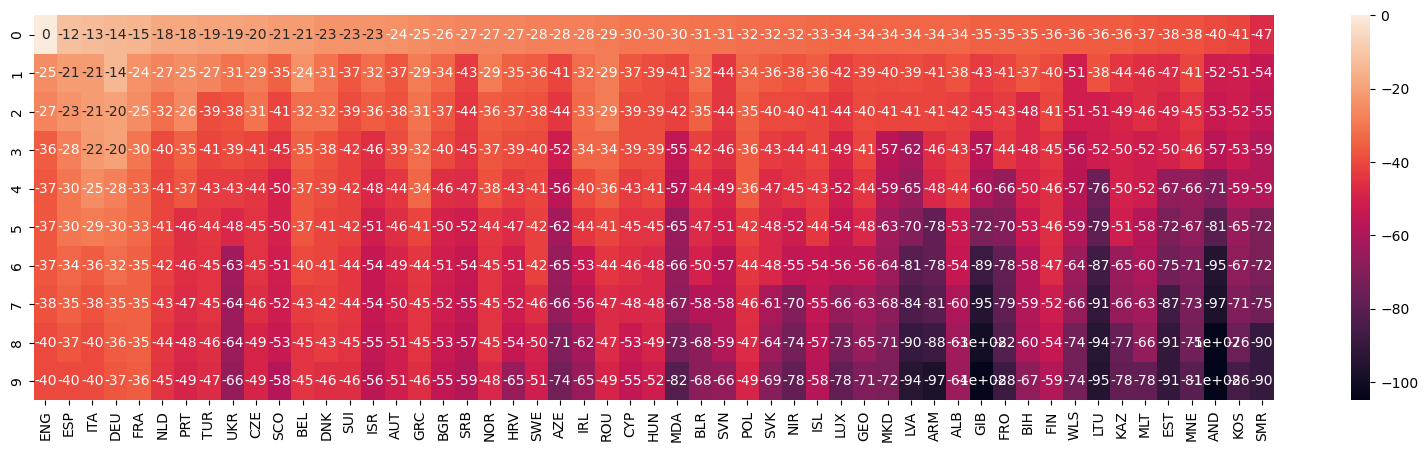

In [637]:
fig, ax = plt.subplots(figsize = (20,5))
sns.heatmap(gaps_to_1st(table)[:10].astype(int), annot = True)

<Axes: >

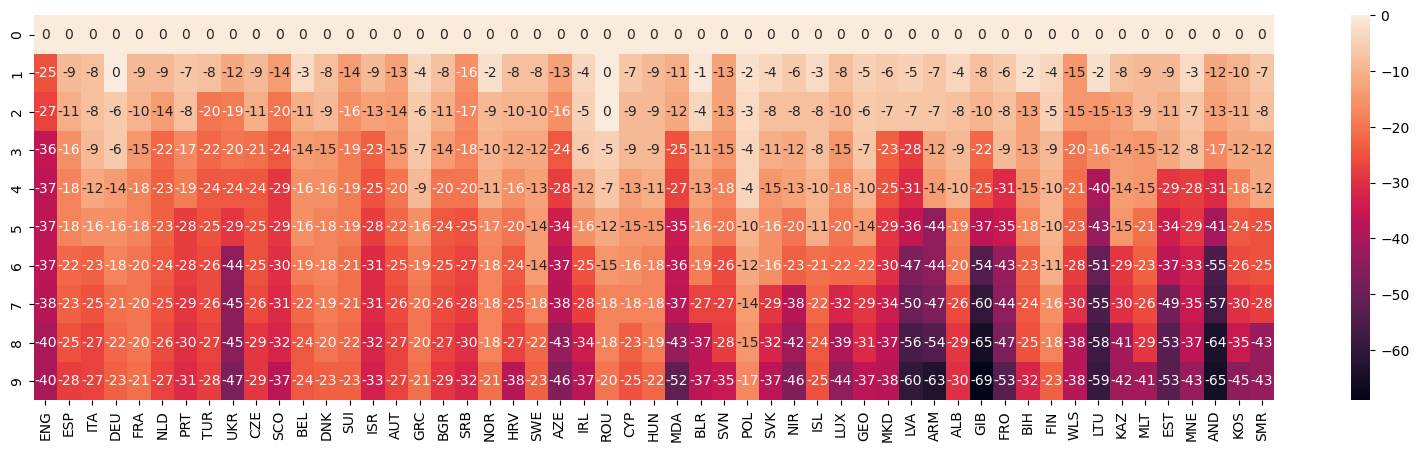

In [638]:
fig, ax = plt.subplots(figsize = (20,5))
sns.heatmap(gaps_to_1st(table, False)[:10].astype(int), annot = True)

In [646]:
table[table.country == 'DEU'][-20:]

,name,country,points,sonneborn-berger
1172,SpVgg Greuther Fürth II,DEU,77,3695
1178,SSVg Velbert,DEU,77,3533
1179,Germania Halberstadt,DEU,77,3518
1181,Eintracht Trier,DEU,77,3487
1186,SV Lichtenberg 47,DEU,77,3343
1224,Kickers Emden,DEU,76,3409
1226,TSV Schott Mainz,DEU,76,3365
1228,TSG Neustrelitz,DEU,76,3156
1263,Rot Weiss Ahlen,DEU,75,3302
1293,SV 19 Straelen,DEU,74,3070


In [640]:
league_table = to.teams_df()[['name','seed','points','byes','country']]

In [641]:
league_table.drop_duplicates('country')

,name,seed,points,byes,country
0,Manchester City,1,141,0,ENG
1,Real Madrid,2,129,0,ESP
2,Inter,3,128,0,ITA
3,Borussia Dortmund,10,127,0,DEU
5,Paris Saint-Germain,8,126,0,FRA
6,PSV Eindhoven,11,123,0,NLD
7,SL Benfica,14,123,0,PRT
8,Galatasaray,34,122,0,TUR
9,Shakhtar Donetsk,61,122,0,UKR
12,Slavia Praha,31,121,0,CZE


# Fixtures

In [293]:
to.fixtures_df('AC Sparta Praha')

,Home,Country1,score1,score2,Country2,Away,Result,Matchday,Designation
306,AC Sparta Praha,CZE,1.0,0.0,CZE,SK Motorlet Praha,AC Sparta Praha,1,domestic
908,Trabzonspor,TUR,0.0,1.0,CZE,AC Sparta Praha,AC Sparta Praha,2,international
2114,AC Sparta Praha,CZE,1.0,0.0,CZE,FC Zlín,AC Sparta Praha,3,domestic
2736,Ternana Calcio,ITA,0.0,1.0,CZE,AC Sparta Praha,AC Sparta Praha,4,international
3899,Slavia Praha,CZE,0.5,0.5,CZE,AC Sparta Praha,draw,5,domestic
4504,AC Sparta Praha,CZE,1.0,0.0,ITA,AS Roma,AC Sparta Praha,6,international
5697,AC Sparta Praha,CZE,1.0,0.0,CZE,FK Jablonec,AC Sparta Praha,7,domestic
6370,Real Madrid,ESP,1.0,0.0,CZE,AC Sparta Praha,Real Madrid,8,international
7526,AC Sparta Praha,CZE,1.0,0.0,CZE,FK Mladá Boleslav,AC Sparta Praha,9,domestic
8173,Atlético Madrid,ESP,1.0,0.0,CZE,AC Sparta Praha,Atlético Madrid,10,international


In [215]:
to.fixtures_df()[to.fixtures_df().Matchday == 48]

,Home,Country1,score1,score2,Country2,Away,Result,Matchday,Designation
37695,Liverpool FC,ENG,0.5,0.5,ENG,Manchester City,draw,48,final
37696,FC Barcelona,ESP,1.0,0.0,ESP,Real Madrid,FC Barcelona,48,final
37697,Borussia Dortmund,DEU,1.0,0.0,DEU,Bayer Leverkusen,Borussia Dortmund,48,final
37698,Paris Saint-Germain,FRA,1.0,0.0,FRA,Lille OSC,Paris Saint-Germain,48,final
37699,Sporting CP,PRT,0.5,0.5,PRT,FC Porto,draw,48,final
37700,Panathinaikos,GRC,1.0,0.0,GRC,AEK Athen,Panathinaikos,48,final
37701,PAOK Saloniki,GRC,1.0,0.0,GRC,Olympiakos Piraeus,PAOK Saloniki,48,final
37702,Slavia Praha,CZE,1.0,0.0,CZE,Viktoria Plzen,Slavia Praha,48,final
37703,Crvena Zvezda,SRB,1.0,0.0,SRB,Partizan,Crvena Zvezda,48,final
37704,Club Brugge KV,BEL,1.0,0.0,BEL,KAA Gent,Club Brugge KV,48,final


In [404]:
league_table[league_table.country == 'ESP'][:20]

,team,country,seed,sonneborn-berger,points,position-seed delta
2,Real Madrid,ESP,2,9170,103,1
8,Atlético Madrid,ESP,9,8285,100,0
67,Real Sociedad,ESP,15,7315,90,53
69,Valencia CF,ESP,60,6916,90,10
91,Girona FC,ESP,22,7172,88,70
129,Real Betis,ESP,47,6615,86,83
163,RCD Mallorca,ESP,76,5841,84,88
191,FC Barcelona,ESP,12,6814,82,180
193,Athletic Bilbao,ESP,18,6707,82,176
214,Villarreal CF,ESP,50,5963,81,165


In [355]:
league_table.drop_duplicates('country')

,team,country,seed,sonneborn-berger,points
0,Manchester City,ENG,1,9819,113
1,Inter,ITA,3,8717,105
2,Real Madrid,ESP,2,9170,103
3,Sporting CP,PRT,17,8486,103
5,PSV Eindhoven,NLD,11,8402,101
6,Paris Saint-Germain,FRA,8,8062,101
7,RB Leipzig,DEU,13,8510,100
9,Galatasaray,TUR,34,6775,100
11,Slavia Praha,CZE,31,7910,97
12,Shakhtar Donetsk,UKR,61,7138,97


# Position-Seed Delta

In [294]:
deltas = []

for idx, row in league_table.iterrows():
    team = row.name
    position = idx + 1
    seed = row.seed
    delta = position - seed
    deltas.append(delta)
    
league_table['position-seed delta'] = deltas 

<Axes: xlabel='margins', ylabel='position-seed delta'>

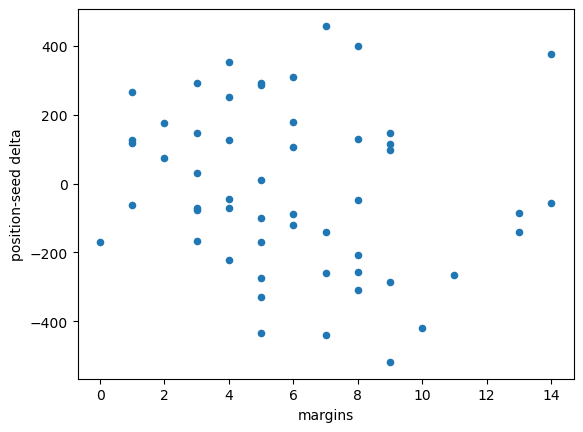

In [295]:
# Examining the relationship between league winning margin and average position-seed delta
league_tables = [league_table[league_table.country == country].reset_index(drop=True) for country in league_table.country.drop_duplicates()]

winning_margin_dict = {}
for table in league_tables:
    if len(table) > 1:
        delta = table['points'][0] - table['points'][1]
        winning_margin_dict[table.country[0]] = delta
    
df = league_table[['position-seed delta','country']].groupby('country').mean()
margins = []
for idx, row in df.iterrows():
    try:
        margins.append(winning_margin_dict[idx])
    except:
        margins.append(None)

df['margins'] = margins

df.dropna(how = 'any').plot(x = 'margins', y = 'position-seed delta',  kind = 'scatter')

In [296]:
df.sort_values(by = 'margins', ascending = False)

,position-seed delta,margins
country,,
KOS,-55.769231,14
ITA,377.000000,14
ARM,-86.571429,13
NLD,-140.265625,13
WLS,-264.250000,11
AND,-418.416667,10
SRB,147.964286,9
FRO,-285.533333,9
GIB,-517.727273,9


<Axes: xlabel='country'>

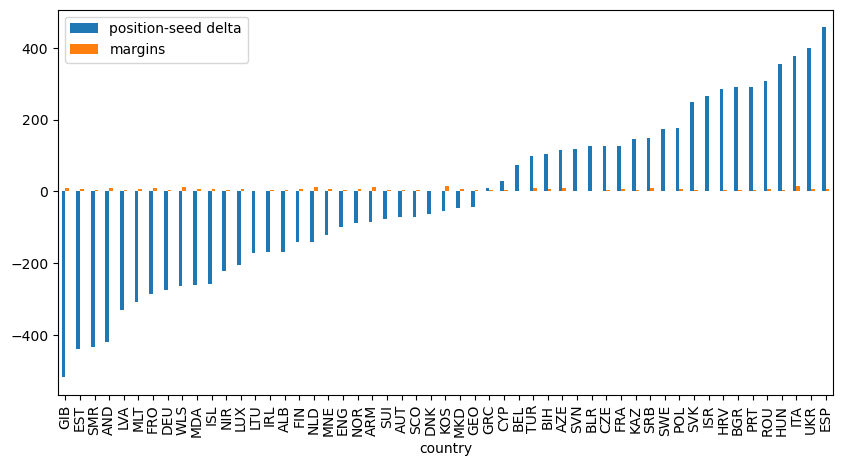

In [297]:
df.sort_values(by = 'position-seed delta').plot.bar(figsize = (10,5))

<Axes: xlabel='country'>

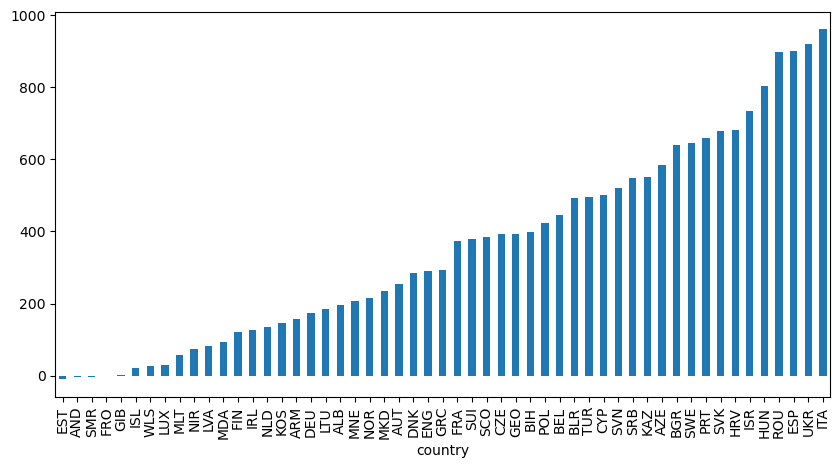

In [298]:
league_table.groupby('country')['position-seed delta'].max().sort_values().plot.bar(figsize = (10,5))

# Byes

In [391]:
teams_df = to.teams_df()
bye_teams = teams_df[teams_df.byes > 0].sort_values('byes', ascending = False)[['name','points','country','byes']]
bye_teams[['country','byes']].groupby('country').sum()

,byes
country,
ALB,40
AUT,40
AZE,40
BGR,40
BIH,40
DNK,40
ENG,40
EST,40
FRA,40


In [393]:
bye_teams

,name,points,country,byes
1812,SK Super Nova,28,LVA,4
1471,FK Tukums 2000,66,LVA,4
793,FK Liepaja,85,LVA,4
1765,Glacis United FC,44,GIB,4
1717,FS Metta/LU,49,LVA,4
...,...,...,...,...
854,SC Kriens,84,SUI,1
853,SAS Épinal,84,FRA,1
851,First Vienna FC,84,AUT,1
848,FC Rouen 1899,84,FRA,1


# Points Distribution

<Axes: >

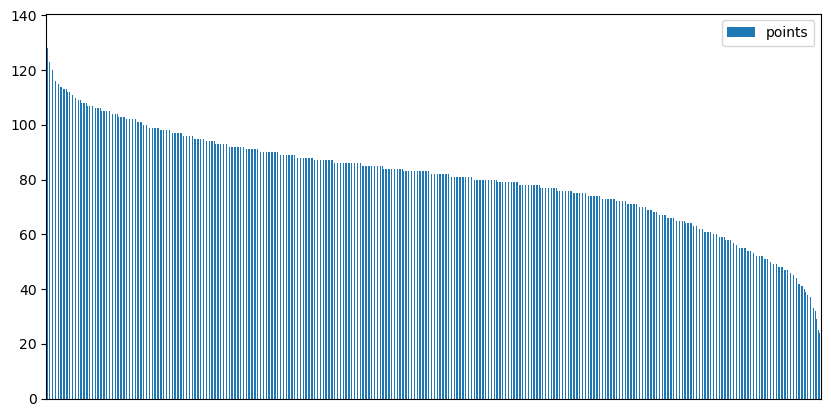

In [394]:
league_table.plot.bar(y = 'points', xticks = [], figsize = (10,5))

<Axes: ylabel='Frequency'>

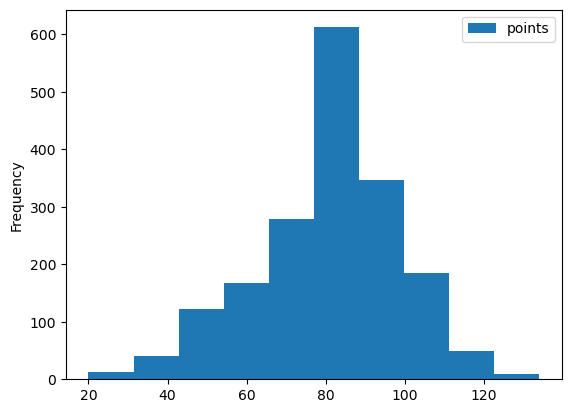

In [306]:
league_table.plot.hist(y = 'points')

<Axes: xlabel='country'>

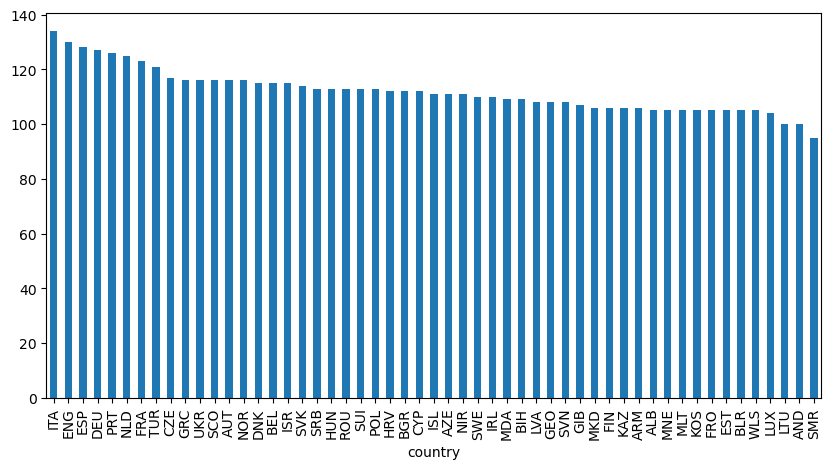

In [307]:
league_table.groupby('country')['points'].max().sort_values(ascending = False).plot.bar(figsize = (10,5))

In [308]:
league_table.drop_duplicates('country')

,name,seed,points,byes,country,position-seed delta
0,Inter,3,134,1,ITA,-2
1,Manchester City,1,130,0,ENG,1
2,Real Madrid,2,128,0,ESP,1
3,Bayer Leverkusen,6,127,0,DEU,-2
4,SL Benfica,14,126,0,PRT,-9
6,PSV Eindhoven,11,125,0,NLD,-4
8,Paris Saint-Germain,8,123,1,FRA,1
11,Galatasaray,34,121,1,TUR,-22
19,AC Sparta Praha,43,117,0,CZE,-23
20,Shakhtar Donetsk,61,116,0,UKR,-40


# Save/Load

In [396]:
import pickle

with open ('TournamentV6_sample.pickle','wb') as file:
    pickle.dump(to, file)

PicklingError: Can't pickle <class '__main__.Tournament'>: it's not the same object as __main__.Tournament

In [397]:
to

In [8]:
import pickle

with open ('TournamentV5_sample.pickle','rb') as file:
    to = pickle.load(file)

# Upset Check

In [418]:
fixtures = to.fixtures_df()

upset_list = []

for idx, row in fixtures.iterrows():
    teams, result = [row.Home, row.Away], row.Result
    seeds = [to.team_dict[x]['seed'] for x in teams]
    
    home_advantage = seeds[0] < seeds[1]
    home_result = result == teams[0]
    
    if result == 'draw':
        text = 'draw'
    else:
        if home_advantage == home_result:
            text = 'hold'
        else:
            text = 'upset'
    upset_list.append(text)

In [419]:
fixtures['upset?'] = upset_list

rate_list = []
for n in range(1, to.matchday + 1):
    mask = fixtures['Matchday'] == n
    result_rates = fixtures[mask].value_counts(subset = 'upset?')/sum(mask)
    rate_list.append(result_rates)

In [429]:
rate_df = pd.DataFrame(rate_list)
rate_df.index = range(1, len(rate_df) + 1)
rate_df

upset?,hold,upset,draw
1,0.782851,0.110245,0.106904
2,0.742762,0.120267,0.136971
3,0.717149,0.155902,0.126949
4,0.704900,0.158129,0.136971
5,0.668151,0.173719,0.158129
6,0.644766,0.182628,0.172606
7,0.621381,0.181514,0.197105
8,0.661470,0.162584,0.175947
9,0.604677,0.218263,0.177060
10,0.629176,0.202673,0.168151


<Axes: >

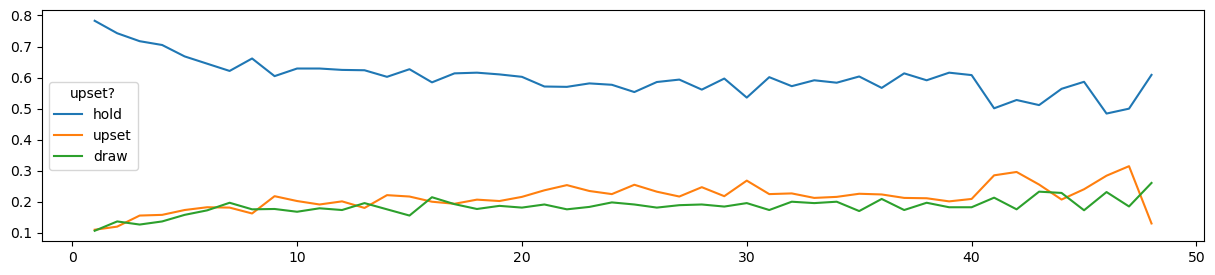

In [431]:
rate_df.plot(figsize = (15,3))

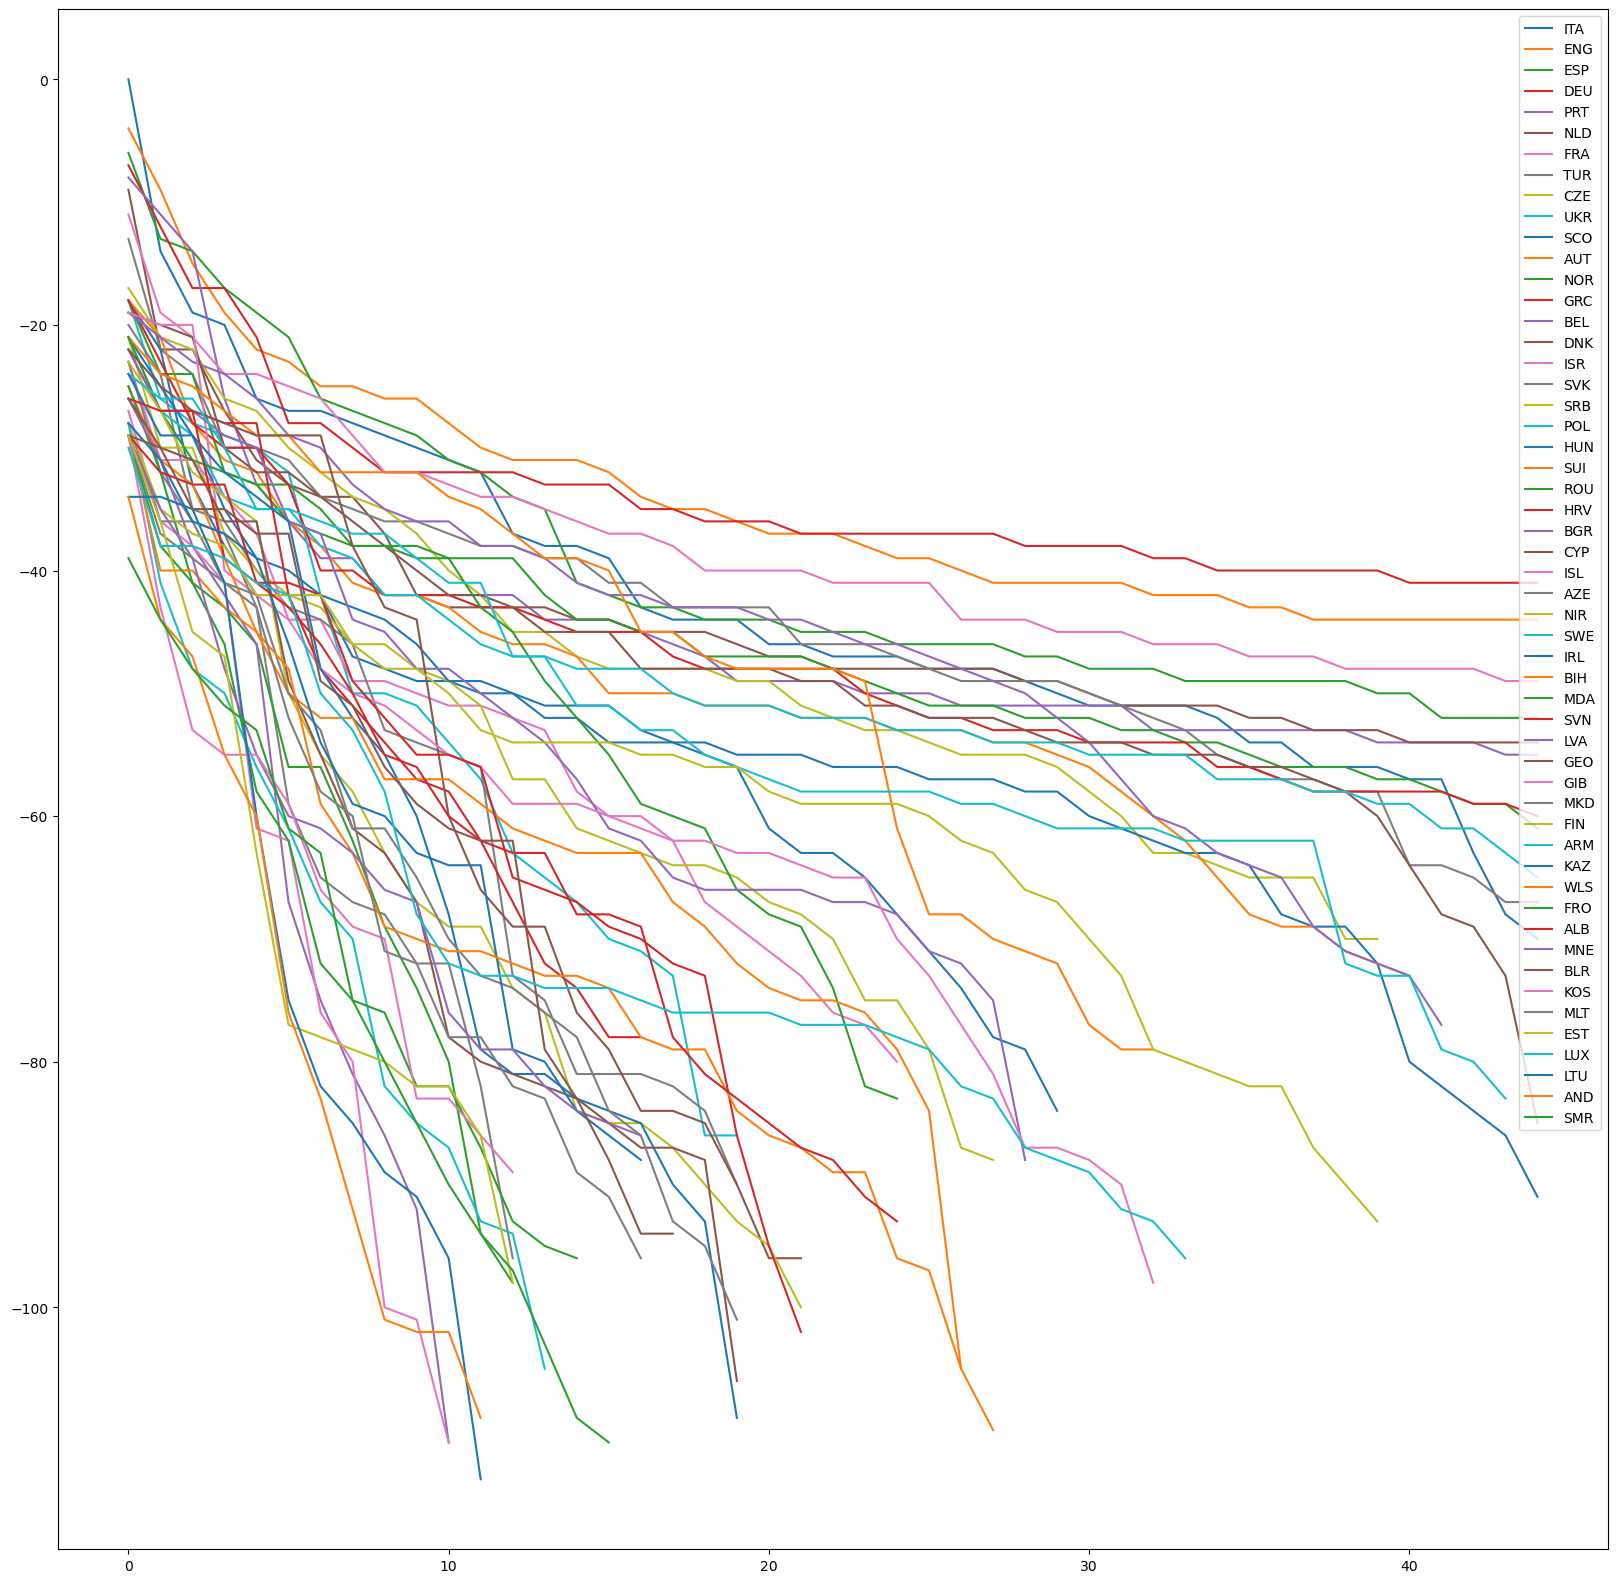

In [326]:
df = gaps_to_1st(table)
ax = df.plot.line(figsize = (20,20))

# for col in df.columns[:]:
#     last_x = len(df[col].dropna())
#     last_y = df[col].iloc[last_x - 1]
#     plt.annotate(f'{col}: {last_y}', xy=(last_x, last_y), xytext=(1, 1), textcoords = 'offset pixels')


# Tiebreaker Check

In [553]:
to.sonneborn_berger()

In [620]:
teams_df = to.teams_df().set_index('name')
tiebreaker_errors = pd.DataFrame(columns = ['team','manual','function','delta','draws','wins'])

for idx, team in teams_df.iterrows():
    tiebreaker1 = team['sonneborn-berger']
    opps_win = team['wins']
    opps_draw = team['draws']
    tiebreaker2 = 0
    for opp in opps_win:
        tiebreaker2 += teams_df.loc[opp]['points'] * 3
    for opp in opps_draw:
        tiebreaker2 += teams_df.loc[opp]['points']

    if tiebreaker1 != tiebreaker2:
        tiebreaker_errors.loc[len(tiebreaker_errors)] = [team.name, tiebreaker1, tiebreaker2, tiebreaker1 - tiebreaker2, len(opps_draw), len(opps_win)]

In [621]:
tiebreaker_errors

,team,manual,function,delta,draws,wins


In [597]:
tiebreaker_errors[tiebreaker_errors.delta != tiebreaker_errors.draws]

,team,manual,function,delta,draws,wins
92,Liverpool FC,133,133,0,1,1
93,Atlético Madrid,133,133,0,1,1
94,RC Lens,133,133,0,1,1
95,Wolverhampton Wanderers,133,133,0,1,1
96,OGC Nice,133,133,0,1,1
...,...,...,...,...,...,...
1782,FC Fiorentino,4,4,0,1,1
1783,FCB Magpies,1,1,0,1,1
1811,Glacis United FC,4,4,0,1,0
1812,UE Engordany,1,1,0,1,0


In [516]:
to.fixtures_df('AC Monza')

,Home,Country1,score1,score2,Country2,Away,Result,Matchday,Designation
113,Reggina 1914,ITA,0.0,1.0,ITA,AC Monza,AC Monza,1,domestic
1093,AC Monza,ITA,1.0,0.0,ITA,Parma Calcio 1913,AC Monza,2,domestic
1912,Frosinone Calcio,ITA,0.0,1.0,ITA,AC Monza,AC Monza,3,domestic
2764,AC Monza,ITA,0.0,1.0,ESP,Atlético Madrid,Atlético Madrid,4,international
3609,AC Monza,ITA,1.0,0.0,ITA,Bologna FC,AC Monza,5,domestic
